# Analysing historical droughts in Loire basin at Blois station

This notebook is used to check and validate the parameters which were calibrated in the HBV_calibration.ipynb notebook. The output of the HBV model for ERA5 forcings is analysed using the drought analyser (from Drought_analyser.ipynb) to detect the periods of drought for the observed values, and the modeled values. These droughts are then compared using a polyfit line, and also the distribution for drought duration and water deficit.

### 1. Importing general python modules

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns
from scipy.stats import wasserstein_distance

#niceties
from rich import print

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# import drought analyser function
%run Drought_analyser.ipynb

### 2. Defining experiment data and paths 
First, the basin data and paths need to be defined. The experiment date is 1990-2019, as there is no further data available in the ERA5 dataset.

In [4]:
# name of the catchment
basin_name = "FR003882"

# defining dates for calibration
experiment_start_date = "1990-01-01"
experiment_end_date = "2019-12-31"

# defining path for catchment shape file
station_shp = Path.home() / "BEP-Loire" / "book" / "model_loire" / "estreams_cb_FR003882.shp"

# defining destination path for ERA5 data
forcing_path_ERA5 = Path.home() / "forcing" / "loire_river" / "ERA5-5-12"
forcing_path_ERA5.mkdir(exist_ok=True)

# model HBV destination path
model_path_HBV = Path.home() / "tmp" / "HBV_model"

gdf = gpd.read_file("estreams_cb_FR003882.shp")
gdf = gdf.to_crs(epsg=2154)
gdf["area_km2"] = gdf.geometry.area / 1e6  
basin_area = gdf["area_km2"].sum()

### 3. Generating ERA5 forcings

The ERA5 forcings can be generated using the marked out code below, or already generated data can be loaded in option two. If the experiment period is too big, generating in multiple smaller periods is recommended. For this, load the data below and store them in a chosen directory. Consult Combine_ERA5_data.ipynb to merge them together.

In [5]:
# Option one: generate forcing:
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
#    dataset="ERA5",
#    directory= str(forcing_path_ERA5),
#    start_time=experiment_start_date,
#    end_time=experiment_end_date,
#    shape=station_shp,
# )

# Option two: Load generated (merged) data
load_location = Path.home() / "forcing" / "loire_river" / "ERA5-90-19"
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

### 4. Defining historical data from eStreams

In [6]:
q_data = pd.read_csv("FR003882_streamflow_m3s.csv", index_col='date', parse_dates=True)[basin_name]
Q_obs = q_data[experiment_start_date:experiment_end_date]

### 5. Defining the parameters (from HBV_calibration.ipynb)

The parameters from the calibration noteboook are defined in this notebook the validate if the parameters are a good fit.

In [7]:
# Best parameters for distribution calibration (N = 2000) (Qcrit = 66.5 m3/s)
par_2000 = [
    6.382012946132834,
    0.6365395937132804,
    366.6921134386536,
    3.275414443053375,
    0.22241595560479888,
    9.260634181675487,
    0.09034248156803193,
    0.0003441943533997508,
    0.026098858621656
]

# Starting values for model storages
#              Si,  Su, Sf, Ss, Sp
s_0 = np.array([0, 150, 0, 15, 0])

### 6. Running the model

In [8]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)
config_file, _ = model.setup(
    parameters=par_2000, 
    initial_storage=s_0,
    cfg_dir = model_path_HBV,
)

In [9]:
model.initialize(config_file)

In [10]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [11]:
model.finalize()

### 7. Show results

To make sure that the HBV model returned credible discharges a first visual check is done. If the discharges are too diviant, the next steps are skipped and new parameters are calibrated.

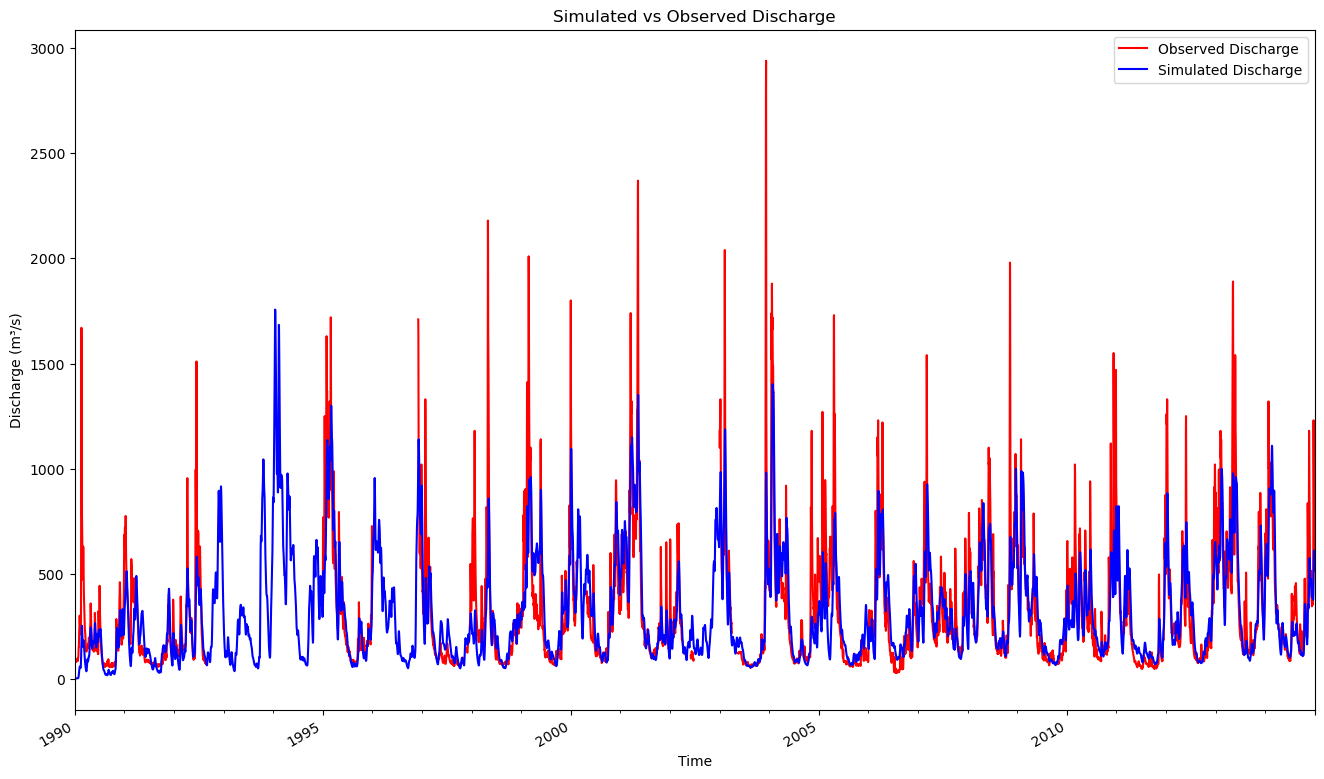

In [12]:
# convert model_output from mm/day to m3/s
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

def convert_Qsim_mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

# get the simulated discharges
Q_sim = convert_Qsim_mmday_to_m3s(model_output.values, basin_area)
Q_sim_pd = pd.Series(Q_sim, index=model_output.index, name="Simulated Discharge")

# get the right period
Q_sim_9719 = Q_sim_pd[experiment_start_date:"2014-12-31"]
Q_obs_9719 = Q_obs[experiment_start_date:"2014-12-31"]

# plot
plt.figure(figsize=(16, 10))
Q_obs_9719.plot(label="Observed Discharge", color='red')
Q_sim_9719.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.show()

### 8. Validation

In this chapter, the modelled output is validated on the chosen validation period. This first by comparing the discharge in the first plot (adjust the ylim to gain a better look on low flows).
Then the droughts are validated using a fitted line for drought duration and deficit. The checks wether the model correctly predicts the relation between duration and deficit. Eventually the distribution is plotted for calibration and validation to check if the results for the two periods are corresponding.

The validation is only done visually using the plots, as this gives a well enough understanding of the modelled results.

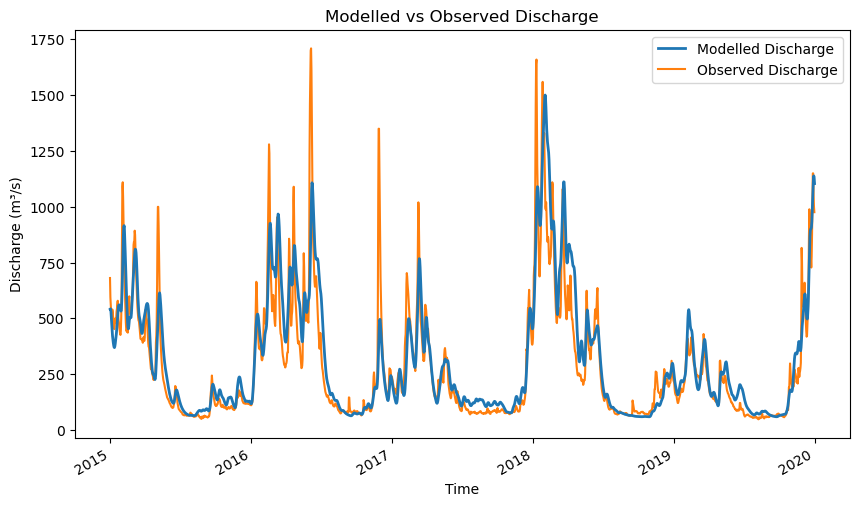

In [13]:
# get the right period
Q_sim_val = Q_sim_pd["2015-01-01":"2019-12-31"]
Q_obs_val = Q_obs["2015-01-01":"2019-12-31"]

# plot
plt.figure(figsize=(10, 6))
Q_sim_val.plot(label="Modelled Discharge", zorder=2, linewidth=2)
Q_obs_val.plot(label="Observed Discharge", zorder=1)
plt.title('Modelled vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
#plt.ylim([0, 300])
plt.legend()
plt.show()

In [14]:
# Calibration
drought_obs_cal = drought_analyser(Q_obs["1991-01-01":"2014-12-31"], basin_name, 66.5)
drought_model_cal = drought_analyser(Q_sim_pd["1991-01-01":"2014-12-31"], 'model output', 66.5)

xoc, yoc = drought_obs_cal["Duration (days)"], drought_obs_cal["Max Cumulative Deficit (m3/s)"]
xmc, ymc = drought_model_cal["Duration (days)"], drought_model_cal["Max Cumulative Deficit (m3/s)"]
coeffsoc = np.polyfit(xoc, yoc, 1)
coeffsmc = np.polyfit(xmc, ymc, 1)
poly_func_oc = np.poly1d(coeffsoc)
poly_func_mc = np.poly1d(coeffsmc)

x_smooth_oc = np.linspace(xoc.min(), xoc.max(), 100)
y_smooth_oc = poly_func_oc(x_smooth_oc)
x_smooth_mc = np.linspace(xmc.min(), xmc.max(), 100)
y_smooth_mc = poly_func_mc(x_smooth_mc)

# Validation
drought_obs_val = drought_analyser(Q_obs["2015-01-01":"2018-12-31"], basin_name, 66.5)
drought_model_val = drought_analyser(Q_sim_pd["2015-01-01":"2018-12-31"], 'model output', 66.5)

xov, yov = drought_obs_val["Duration (days)"], drought_obs_val["Max Cumulative Deficit (m3/s)"]
xmv, ymv = drought_model_val["Duration (days)"], drought_model_val["Max Cumulative Deficit (m3/s)"]
coeffsov = np.polyfit(xov, yov, 1)
coeffsmv = np.polyfit(xmv, ymv, 1)
poly_func_ov = np.poly1d(coeffsov)
poly_func_mv = np.poly1d(coeffsmv)

x_smooth_ov = np.linspace(xov.min(), xov.max(), 100)
y_smooth_ov = poly_func_ov(x_smooth_ov)
x_smooth_mv = np.linspace(xmv.min(), xmv.max(), 100)
y_smooth_mv = poly_func_mv(x_smooth_mv)

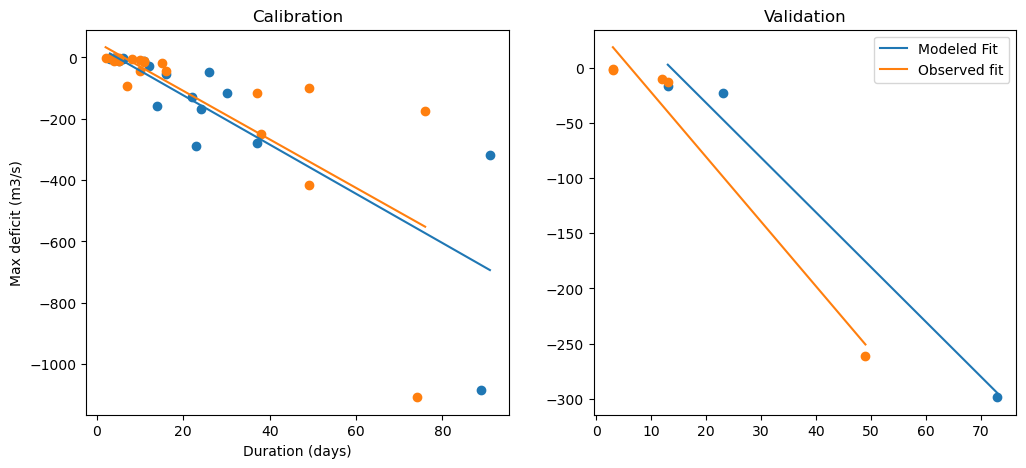

In [15]:
# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Calibration
plt.subplot(1, 2, 1)
plt.plot(x_smooth_mc, y_smooth_mc, label="Modeled Fit")
plt.plot(x_smooth_oc, y_smooth_oc, label="Observed fit")

plt.scatter(xmc, ymc)
plt.scatter(xoc, yoc)

plt.xlabel('Duration (days)')
plt.ylabel('Max deficit (m3/s)')
plt.title('Calibration')

# Plot 2: Validation
plt.subplot(1, 2, 2)
plt.plot(x_smooth_mv, y_smooth_mv, label="Modeled Fit")
plt.plot(x_smooth_ov, y_smooth_ov, label="Observed fit")

plt.scatter(xmv, ymv)
plt.scatter(xov, yov)

plt.title('Validation')
plt.legend()

plt.show()

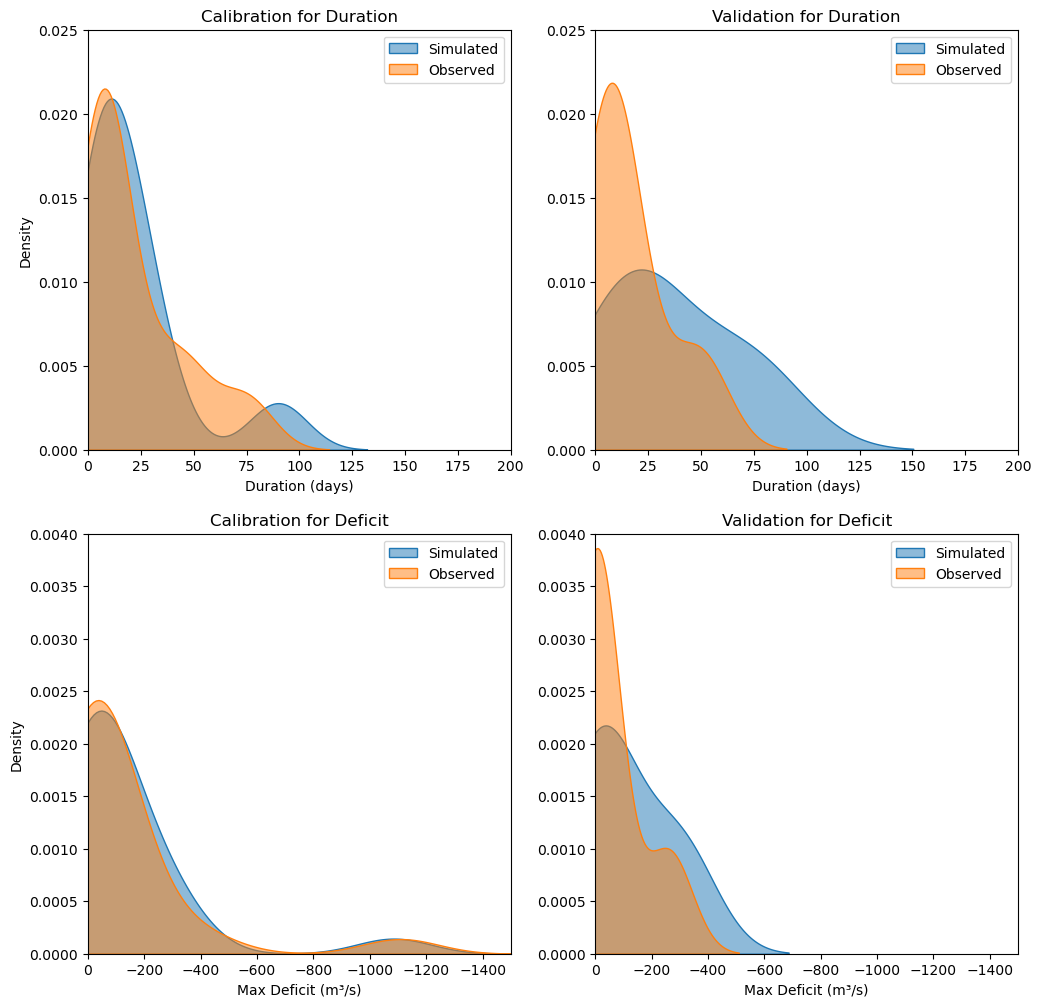

In [16]:
# Plotting
plt.figure(figsize=(12, 12))

# Plot 1: Calibration Duration
plt.subplot(2, 2, 1)
sns.kdeplot(xmc, label='Simulated', fill=True, alpha=0.5, common_norm=False)
sns.kdeplot(xoc, label='Observed', fill=True, alpha=0.5, common_norm=False)
plt.title('Calibration for Duration')
plt.xlabel('Duration (days)')
#plt.ylabel('Density')
plt.xlim(0, 200)
plt.ylim(0, 0.025)
plt.legend()

# Plot 2: Validation Duration
plt.subplot(2, 2, 2)
sns.kdeplot(xmv, label='Simulated', fill=True, alpha=0.5, common_norm=False)
sns.kdeplot(xov, label='Observed', fill=True, alpha=0.5, common_norm=False)
plt.title('Validation for Duration')
plt.xlabel('Duration (days)')
plt.ylabel('')
plt.xlim(0, 200)
plt.ylim(0, 0.025)
plt.legend()

# Plot 3: Calibration Deficit
plt.subplot(2, 2, 3)
sns.kdeplot(ymc, label='Simulated', fill=True, alpha=0.5, common_norm=False)
sns.kdeplot(yoc, label='Observed', fill=True, alpha=0.5, common_norm=False)
plt.title('Calibration for Deficit')
plt.xlabel('Max Deficit (m³/s)')
#plt.ylabel('Density')
plt.xlim(-1500, 0)
plt.ylim(0, 0.004)
plt.gca().invert_xaxis()
plt.legend()

# Plot 4: Validation Deficit
plt.subplot(2, 2, 4)
sns.kdeplot(ymv, label='Simulated', fill=True, alpha=0.5, common_norm=False)
sns.kdeplot(yov, label='Observed', fill=True, alpha=0.5, common_norm=False)
plt.title('Validation for Deficit')
plt.xlabel('Max Deficit (m³/s)')
plt.ylabel('')
plt.xlim(-1500, 0)
plt.ylim(0, 0.004)
plt.gca().invert_xaxis()
plt.legend()